In [1]:
from magpi.prelude import *
from magpi.integrate import gauss, integrate, integrate_sphere
from magpi.calc import *
from magpi.opt import TR
import matplotlib.pyplot as plt
from magpi import r_fun
from magpi.domain import Sphere
from scipy.stats.qmc import Halton, Sobol
from magpi.surface_integral import charge_tensor, source_tensor, single_layer_potential, curl_single_layer_potential, integrate_surface, scalar_potential_charge, vector_potential_charge

%matplotlib widget

# Demagnetization of a hard magnetic cube using scalar and vector potential with an ELM ansatz for $\phi_1$ and $A_1$ and L-BFGS optimization

This notebook is similar to `demag_cube_elm.ipynb` but uses L-BFGS instead of Trust Region.

In [2]:
mu0 = 4*pi*10**-7  # Tm/A
Js = 1.61  # T
Ms = Js / mu0  # A/m
Km = mu0 * Ms**2  # J/m3
L = 70.0  # nm
Ka = 4.3e6 / Km  # -
A = 7.3e-12 / Km * 1e18 / L ** 2 # 1/nm2
unit_vec = lambda x: x / norm(x, axis=-1, keepdims=True)
dh = 5e-3
hext = jnp.arange(-3.5, 1., dh)[::-1]  # -
hext_axis = unit_vec(array([1., 0., 10.]))
m0 = lambda x: zeros_like(x).at[..., 2].set(1.)

In [3]:
from magpi.domain import Hypercube

lb, ub = -0.5, 0.5
cube = Hypercube((lb,lb,lb), (ub, ub, ub))

@partial(jit, static_argnames=("i",))
def parametrization(x, i):
    assert 0 <= i and i <= 5
    assert x.shape[-1] == 2
    if i <= 2:
        c = 0.0
        d = i
    else:
        c = 1.0
        d = i % 3
    return cube.transform(jnp.insert(x, d, c, axis=-1))


k = 7
u = jnp.linspace(0, 1, k)
v = jnp.linspace(0, 1, k)
def compute_source(x):
    _z = [source_tensor(x, lambda x: parametrization(x, i), u, v, method=gauss(10), compute_jacfwd=True) for i in range(6)]
    z, dz = zip(*_z)
    return jnp.concatenate(list(z), axis=0), jnp.concatenate(list(dz), axis=0)
    
def compute_charge(f, *args, **kwargs):
    _c = [charge_tensor(f, lambda x: parametrization(x, i), u, v, *args, order=2, **kwargs) for i in range(6)]
    return jnp.concatenate(_c, axis=0)


adf = r_fun.cube(ub - lb, centering=True)

X = array(Halton(3, seed=0).random(2 ** 12))
X = cube.transform(X)
Z, dZ = lax.map(compute_source, X)

X_val = array(Halton(3, seed=1562).random(2 ** 10))
X_val = cube.transform(X_val)


In [4]:
key = random.key(0)
m_init = lambda x: zeros_like(x).at[..., -1].set(1.0)

l2_reg = 1e-3

_weights = array(Halton(4, seed=43).random(2 ** 9))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2
h_elm = lambda x: nn.tanh(W_elm @ x + b_elm)
u_elm = lambda x: h_elm(x) * adf(x)
Q_phi1 = vmap(lambda x: -laplace(u_elm)(x))(X)

U_phi1, S_phi1, VT_phi1 = jax.scipy.linalg.svd(
    Q_phi1, full_matrices=False, lapack_driver="gesvd"
)
Pinv_phi1 = VT_phi1.T * (S_phi1 / (S_phi1 ** 2 + l2_reg)) @ U_phi1.T

@jit
def solve_phi1(params_m):
    f = lambda x: -divergence(mag)(x, params_m)
    b = vmap(f)(X)
    params_phi1 = Pinv_phi1 @ b
    return params_phi1

def phi1(x, params):
    return h_elm(x) @ params


W_m = array(Halton(3, seed=43).random(2 ** 9))
W_m = cube.transform(W_m)

class PINN(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 16
        activation = nn.gelu
        y = activation(nn.Dense(nodes, kernel_init=nn.initializers.he_normal())(x))
        y = activation(nn.Dense(nodes, kernel_init=nn.initializers.he_normal())(y))
        y = nn.Dense(3, kernel_init=nn.initializers.he_normal())(y)
        return y
    
    
key, _k = random.split(key)
mag_pinn_model = PINN()
pinn_params_init = mag_pinn_model.init(_k, zeros((3,)))

def to_skew_simmetric_matrix(x):
    S = zeros((3, 3))
    S = S.at[1, 0].set(x[2])
    S = S.at[2, 0].set(-x[1])
    S = S.at[2, 1].set(x[0])
    S = S - S.T
    return S

def cayley_rotation(p, x):
    assert p.shape[0] == 3, f"{p.shape}"
    Q = to_skew_simmetric_matrix(p)
    I = jnp.eye(3)
    return jnp.linalg.inv(I - Q) @ (I + Q) @ x


def mag(x, params):
    p = mag_pinn_model.apply(params, x)
    m = m_init(x)
    return cayley_rotation(p, m)


def exchange_energy(x, params_m):
    dm = jacfwd(mag)(x, params_m)
    return A * jnp.sum(dm * dm)

def ani_energy(x, params_m):
    c = array([0., 0., 1.])
    return Ka * (1 - (mag(x, params_m) @ c) ** 2)

def ext_energy(x, params_m, hext, hext_axis):
    return - mag(x, params_m) @ (hext * hext_axis)

def solve_phi12(mag, phi1, params_mag=(), params_phi1=()):
    charge_fn = scalar_potential_charge(adf, mag, phi1, normalized=True)
    c = compute_charge(charge_fn, params_mag=params_mag, params_phi1=params_phi1)
    
    def solve(z, grad_z):
        phi2 = single_layer_potential(z, c)
        Jphi2 = single_layer_potential(grad_z, c)
        return phi2, Jphi2#, curl_A2
    
    return solve

def mag_energy(x, z, dz, params_m, phi1, phi2_Jphi1):
    m = lambda x: mag(x, params_m)
    Jphi1 = jacfwd(phi1)(x)
    phi2, Jphi2 = phi2_Jphi1(z, dz)
    
    h = - (Jphi1 + Jphi2)
    lower_bound = -jnp.sum(Jphi1 * Jphi1) + 2 * m(x) @ (Jphi1 + Jphi2) - (divergence(m)(x) * phi2 + m(x) @ Jphi2 - laplace(phi1)(x) * phi2 - Jphi1 @ Jphi2)

    return 1 / 2 * (- (m(x) @ h)), 1 / 2 * lower_bound

def _integrand(x_z_dz, params_m, params_old, hext, hext_axis, phi2_Jphi1):
    x, z, dz = x_z_dz
    _, params_phi1_old = params_old
    _phi1 = lambda x: adf(x) * phi1(x, params_phi1_old)
    e_d, lower_bound = mag_energy(x, z, dz, params_m, _phi1, phi2_Jphi1)
    return dict(
        e_ex = exchange_energy(x, params_m),
        e_ani = ani_energy(x, params_m),
        e_ext = ext_energy(x, params_m, hext, hext_axis),
        e_d = e_d,
        lower_bound=lower_bound
    )

def mc_integrate(f, X, *args, **kwargs):
    return tree_map(partial(mean, axis=0), vmap(lambda x: f(x, *args, *kwargs))(X))

@jit
def loss_m(params_m, params_old, hext, hext_axis, data):
    params_m_old, params_phi1_old = params_old
    phi2_Jphi1 = solve_phi12(mag, phi1, (params_m_old,), (params_phi1_old,))
    energies = mc_integrate(_integrand, data, params_m, params_old, hext, hext_axis, phi2_Jphi1)
    l = (energies["e_ex"] + energies["e_ani"] + energies["e_ext"] + 2 * energies["e_d"])
    e_tot = (energies["e_ex"] + energies["e_ani"] + energies["e_ext"] + energies["e_d"])
    energies |= {"e_tot": e_tot}
    return l, energies


In [5]:
from jaxopt import LBFGS, OptStep

@partial(jit, static_argnames=("solver",))
def run(solver, params, state, hext, hext_axis, data):
    params_m, _ = params
    state = state._replace(iter_num=0)
    step = OptStep(params_m, state)
    params_m_new, state = solver.run(step, params, hext, hext_axis, data)
    params_phi1_new = solve_phi1(params_m_new)
    return (params_m_new, params_phi1_new), state


hist_scalar_pot = []
def update_hist(params, state, iter_num):
    h = {
        "value_m": state.value,
        "error_m": state.error,
        "aux_m": state.aux,
        "iter_num_m": state.iter_num,
        "iter_num": iter_num,
        "mean_mag": mean_mag(params[0], hext_axis)
    }
    hist_scalar_pot.append(h)
    return h

@jit
def mean_mag(params, hext_axis):
    m = lambda x: mag(x, params)
    def m_proj(x):
        return m(x) @ hext_axis
    return mean(vmap(m_proj)(X_val))

tol_m = 1e-3
def solve(params, state, hext, hext_axis): 
    for i in range(400):
        params, state = run(solver, params, state, hext, hext_axis, (X, Z, dZ))
        error = tree_l2_norm(solver.optimality_fun(params[0], params, hext, hext_axis, (X, Z, dZ)))
        if error < tol_m:
            break
    return params, state, i

solver = LBFGS(loss_m, has_aux=True, maxiter=10, tol=tol_m, unroll=False, history_size=20)

phi1_params_init = solve_phi1(pinn_params_init)
params = (pinn_params_init, phi1_params_init)
hext_init = 1.0
state = solver.init_state(params[0], params, hext_init, hext_axis, (X, Z, dZ))


In [6]:
hist_scalar_pot = []
_params = params
for h in hext:
    print(h)
    _params, state, iter_num = solve(_params, state, h, hext_axis)
    _hist = update_hist(_params, state, iter_num)
    if _hist["mean_mag"] < 0:
        # restart the optmizer after switching
        state = solver.init_state(params[0], params, hext_init, hext_axis, (X, Z, dZ))

0.9951029
0.99010277
0.98510265
0.98010254
0.9751024
0.9701023
0.9651022
0.9601021
0.95510197
0.95010185
0.94510174
0.9401016
0.9351015
0.9301014
0.9251013
0.92010117
0.91510105
0.91010094
0.9051008
0.9001007
0.8951006
0.8901005
0.88510036
0.88010025
0.87510014
0.8701
0.8650999
0.8600998
0.8550997
0.85009956
0.84509945
0.84009933
0.8350992
0.8300991
0.825099
0.8200989
0.81509876
0.81009865
0.80509853
0.8000984
0.7950983
0.7900982
0.7850981
0.78009796
0.77509785
0.77009773
0.7650976
0.7600975
0.7550974
0.7500973
0.74509716
0.74009705
0.73509693
0.7300968
0.7250967
0.7200966
0.7150965
0.71009636
0.70509624
0.70009613
0.695096
0.6900959
0.6850958
0.6800957
0.67509556
0.67009544
0.6650953
0.6600952
0.6550951
0.650095
0.6450949
0.64009476
0.63509464
0.6300945
0.6250944
0.6200943
0.6150942
0.6100941
0.60509396
0.60009384
0.5950937
0.5900936
0.5850935
0.5800934
0.57509327
0.57009315
0.56509304
0.5600929
0.5550928
0.5500927
0.5450926
0.54009247
0.53509235
0.53009224
0.5250921
0.520092
0.515091

In [7]:
key = random.key(0)
m_init = lambda x: zeros_like(x).at[..., -1].set(1.0)

l2_reg = 1e-3

_weights = array(Halton(4, seed=43).random(2 ** 9))
W_elm = (_weights[:, :3] * 2 - 1) * 2
b_elm = (_weights[:, 3] * 2 - 1) * 2
h_elm = lambda x: nn.tanh(W_elm @ x + b_elm)
u_elm = lambda x: h_elm(x) * adf(x)
Q_A1 = vmap(lambda x: laplace(u_elm)(x))(X)

U_A1, S_A1, VT_A1 = jax.scipy.linalg.svd(
    Q_A1, full_matrices=False, lapack_driver="gesvd"
)
Pinv_A1 = VT_A1.T * (S_A1 / (S_A1 ** 2 + l2_reg)) @ U_A1.T


@jit
def solve_A1(params_m):
    f = lambda x: -curl(mag)(x, params_m)
    b = vmap(f)(X)
    params_A1 = Pinv_A1 @ b
    return params_A1

def A1(x, params):
    return h_elm(x) @ params


class PINN(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 16
        activation = nn.gelu
        y = activation(nn.Dense(nodes, name="dense1", kernel_init=nn.initializers.he_normal())(x))
        y = activation(nn.Dense(nodes, name="dense2", kernel_init=nn.initializers.he_normal())(y))
        y = nn.Dense(3, name="dense4", kernel_init=nn.initializers.he_normal())(y)
        return y

key, _k = random.split(key)
mag_pinn_model = PINN()
pinn_params_init = mag_pinn_model.init(_k, zeros((3,)))

def to_skew_simmetric_matrix(x):
    S = zeros((3, 3))
    S = S.at[1, 0].set(x[2])
    S = S.at[2, 0].set(-x[1])
    S = S.at[2, 1].set(x[0])
    S = S - S.T
    return S

def cayley_rotation(p, x):
    assert p.shape[0] == 3, f"{p.shape}"
    Q = to_skew_simmetric_matrix(p)
    I = jnp.eye(3)
    return jnp.linalg.inv(I - Q) @ (I + Q) @ x


def mag(x, params):
    p = mag_pinn_model.apply(params, x)
    m = m_init(x)
    return cayley_rotation(p, m)


def exchange_energy(x, params_m):
    dm = jacfwd(mag)(x, params_m)
    return A * jnp.sum(dm * dm)

def ani_energy(x, params_m):
    c = array([0., 0., 1.])
    return Ka * (1 - (mag(x, params_m) @ c) ** 2)

def ext_energy(x, params_m, hext, hext_axis):
    return - mag(x, params_m) @ (hext * hext_axis)

def solve_A2(mag, A1, params_mag=(), params_A1=()):
    charge_fn = vector_potential_charge(adf, mag, A1, normalized=True)
    c = compute_charge(charge_fn, params_mag=params_mag, params_A1=params_A1)
    
    def solve(z, grad_z):
        A2 = single_layer_potential(z, c)
        JA2 = single_layer_potential(grad_z, c)
        curl_A2 = curl_single_layer_potential(grad_z, c)
        return A2, JA2, curl_A2
    
    return solve

def mag_energy(x, z, dz, params_m, A1, A2_JA2_curlA2):
    m = lambda x: mag(x, params_m)
    JA1 = jacfwd(A1)(x)
    curl_A1 = curl(A1)(x)
    A2, JA2, curl_A2 = A2_JA2_curlA2(z, dz)
    _curl_A = curl_A1 + curl_A2
    upper_bound = (norm(m(x)) ** 2 + jnp.sum(JA1 * JA1) - 2 * m(x) @ _curl_A -
                    curl(m)(x) @ A2 + m(x) @ curl_A2 - laplace(A1)(x) @ A2)

    return 1 / 2 * (1 - (m(x) @ _curl_A)), 1 / 2 * upper_bound

def _integrand(x_z_dz, params_m, params_old, hext, hext_axis, A2_JA2_curlA2):
    x, z, dz = x_z_dz
    _, params_A1_old = params_old
    _A1 = lambda x: adf(x) * A1(x, params_A1_old)
    e_d, upper_bound = mag_energy(x, z, dz, params_m, _A1, A2_JA2_curlA2)
    return dict(
        e_ex = exchange_energy(x, params_m),
        e_ani = ani_energy(x, params_m),
        e_ext = ext_energy(x, params_m, hext, hext_axis),
        e_d = e_d,
        upper_bound=upper_bound
    )

def mc_integrate(f, X, *args, **kwargs):
    return tree_map(partial(mean, axis=0), vmap(lambda x: f(x, *args, *kwargs))(X))

@jit
def loss_m(params_m, params_old, hext, hext_axis, data):
    params_m_old, params_A1_old = params_old
    A2_JA2_curlA2 = solve_A2(mag, A1, (params_m_old,), (params_A1_old,))
    energies = mc_integrate(_integrand, data, params_m, params_old, hext, hext_axis, A2_JA2_curlA2)
    l = (energies["e_ex"] + energies["e_ani"] + energies["e_ext"] + 2 * energies["e_d"])
    e_tot = (energies["e_ex"] + energies["e_ani"] + energies["e_ext"] + energies["e_d"])
    energies |= {"e_tot": e_tot}
    return l, energies

In [8]:
from jaxopt import LBFGS, OptStep
from magpi.tr import TR

@partial(jit, static_argnames=("solver",))
def run(solver, params, state, hext, hext_axis, data):
    params_m, _ = params
    state = state._replace(iter_num=0)
    step = OptStep(params_m, state)
    params_m_new, state = solver.run(step, params, hext, hext_axis, data)
    params_A1_new = solve_A1(params_m_new)
    return (params_m_new, params_A1_new), state


hist_vec_pot = []
def update_hist(params, state, iter_num):
    h = {
        "value_m": state.value,
        "error_m": state.error,
        "aux_m": state.aux,
        "iter_num_m": state.iter_num,
        "iter_num": iter_num,
        "mean_mag": mean_mag(params[0], hext_axis)
    }
    hist_vec_pot.append(h)
    return h
    

@jit
def mean_mag(params, hext_axis):
    m = lambda x: mag(x, params)
    def m_proj(x):
        return m(x) @ hext_axis
    return mean(vmap(m_proj)(X_val))

tol_m = 1e-3
def solve(params, state, hext, hext_axis): 
    for i in range(400):
        params, state = run(solver, params, state, hext, hext_axis, (X, Z, dZ))
        error = tree_l2_norm(solver.optimality_fun(params[0], params, hext, hext_axis, (X, Z, dZ)))
        if error < tol_m:
            break
    return params, state, i

solver = LBFGS(loss_m, has_aux=True, maxiter=10, tol=tol_m, unroll=False, history_size=20)

vec_pot_params_init = solve_A1(pinn_params_init)
params = (pinn_params_init, vec_pot_params_init)
hext_init = 1.0
state = solver.init_state(params[0], params, hext_init, hext_axis, (X, Z, dZ))

In [9]:
hist_vec_pot = []
_params = params
for h in hext:
    print(h)
    _params, state, iter_num = solve(_params, state, h, hext_axis)
    _hist = update_hist(_params, state, iter_num)
    if _hist["mean_mag"] < 0:
        # restart the optmizer after switching
        state = solver.init_state(params[0], params, hext_init, hext_axis, (X, Z, dZ))
    

0.9951029
0.99010277
0.98510265
0.98010254
0.9751024
0.9701023
0.9651022
0.9601021
0.95510197
0.95010185
0.94510174
0.9401016
0.9351015
0.9301014
0.9251013
0.92010117
0.91510105
0.91010094
0.9051008
0.9001007
0.8951006
0.8901005
0.88510036
0.88010025
0.87510014
0.8701
0.8650999
0.8600998
0.8550997
0.85009956
0.84509945
0.84009933
0.8350992
0.8300991
0.825099
0.8200989
0.81509876
0.81009865
0.80509853
0.8000984
0.7950983
0.7900982
0.7850981
0.78009796
0.77509785
0.77009773
0.7650976
0.7600975
0.7550974
0.7500973
0.74509716
0.74009705
0.73509693
0.7300968
0.7250967
0.7200966
0.7150965
0.71009636
0.70509624
0.70009613
0.695096
0.6900959
0.6850958
0.6800957
0.67509556
0.67009544
0.6650953
0.6600952
0.6550951
0.650095
0.6450949
0.64009476
0.63509464
0.6300945
0.6250944
0.6200943
0.6150942
0.6100941
0.60509396
0.60009384
0.5950937
0.5900936
0.5850935
0.5800934
0.57509327
0.57009315
0.56509304
0.5600929
0.5550928
0.5500927
0.5450926
0.54009247
0.53509235
0.53009224
0.5250921
0.520092
0.515091

## Computation of the switching field

In [15]:
import numpy as np
from scipy.optimize import bisect

mean_mags = asarray([h["mean_mag"] for h in hist_scalar_pot])

def _g(x):
    return np.array(jnp.interp(x, hext[:len(mean_mags)][::-1], asarray(mean_mags)[::-1]))

hsw_scalar_pot = bisect(_g, -3.5, 1)
hsw_scalar_pot

-2.762416005134014

In [17]:
import numpy as np
from scipy.optimize import bisect

mean_mags = asarray([h["mean_mag"] for h in hist_vec_pot])

def _g(x):
    return np.array(jnp.interp(x, hext[:len(mean_mags)][::-1], asarray(mean_mags)[::-1]))

hsw_vec_pot = bisect(_g, -3.5, 1)

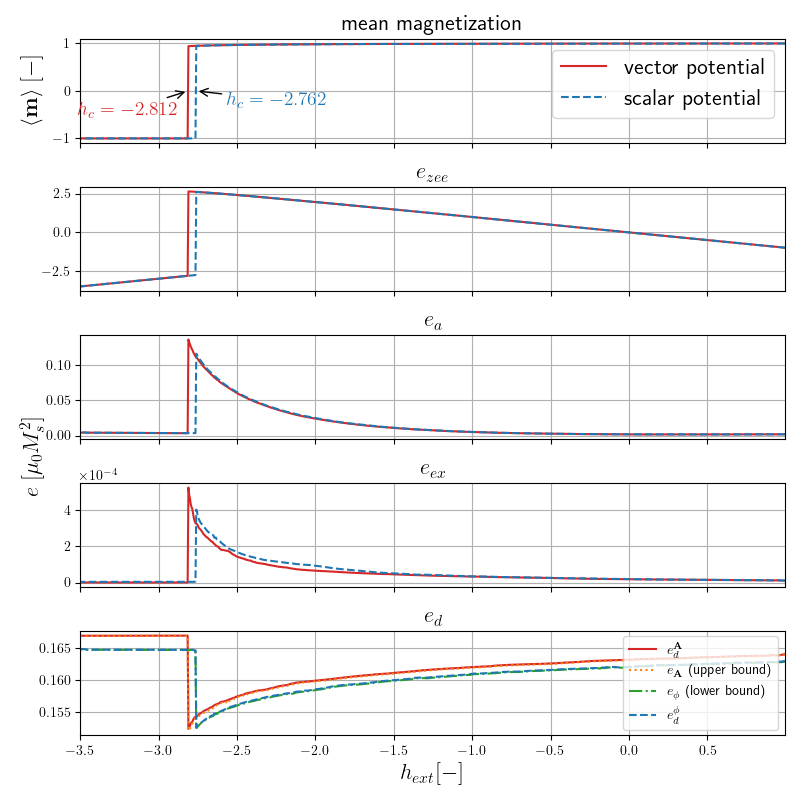

In [19]:

with plt.rc_context(rc={'text.usetex': True, 'text.latex.preamble': r"\usepackage{amsmath}", "axes.labelsize": 16, "axes.titlesize": 16}):
    fig = plt.figure(figsize=(8, 8))
    ax1, ax2, ax3, ax4, ax5 = fig.subplots(5, 1, sharex=True)
    ax1.plot(hext[:len(hist_vec_pot)],  [h["mean_mag"] for h in hist_vec_pot], c="tab:red", label="vector potential")
    ax1.set_title("mean magnetization", fontsize=16)
    ax1.grid()
    ax1.annotate(f"$h_c={hsw_vec_pot:.3f}$", (hsw_vec_pot, 0), (hsw_vec_pot - 0.7, -0.5), xycoords="data", fontsize=14, arrowprops={"arrowstyle": "->"}, color="tab:red")
    ax2.plot(hext[:len(hist_vec_pot)], [h["aux_m"]["e_ext"] for h in hist_vec_pot], c="tab:red")
    ax2.set_title("$e_{zee}$", fontsize=16)
    ax2.grid()

    ax3.plot(hext[:len(hist_vec_pot)], [h["aux_m"]["e_ani"] for h in hist_vec_pot], c="tab:red")
    ax3.set_title("$e_{a}$", fontsize=16)
    ax3.grid()
    ax4.ticklabel_format(axis="y", style="sci", useOffset=True, scilimits=(0,0))
    ax4.plot(hext[:len(hist_vec_pot)], [h["aux_m"]["e_ex"] for h in hist_vec_pot], c="tab:red")
    ax4.set_title("$e_{ex}$", fontsize=16)
    ax4.grid()
    ax5.plot(hext[:len(hist_vec_pot)], [(h["aux_m"]["e_d"]) for h in hist_vec_pot], label=r"$e_d^{\mathbf{A}}$", c="tab:red")
    ax5.plot(hext[:len(hist_vec_pot)], [(h["aux_m"]["upper_bound"]) for h in hist_vec_pot], linestyle="dotted", label=r"$e_\mathbf{A}$ (upper bound)", c="tab:orange")
    
    ax1.plot(hext[:len(hist_scalar_pot)], [h["mean_mag"] for h in hist_scalar_pot], "--", c="tab:blue", label="scalar potential")
    ax1.annotate(f"$h_c={hsw_scalar_pot:.3f}$", (hsw_scalar_pot, 0), (hsw_scalar_pot + 0.2, -0.3), xycoords="data", fontsize=14, arrowprops={"arrowstyle": "->"}, color="tab:blue")
    ax2.plot(hext[:len(hist_scalar_pot)], [h["aux_m"]["e_ext"] for h in hist_scalar_pot], "--", c="tab:blue")
    ax3.plot(hext[:len(hist_scalar_pot)], [h["aux_m"]["e_ani"] for h in hist_scalar_pot], "--", c="tab:blue")
    
    ax4.plot(hext[:len(hist_scalar_pot)], [h["aux_m"]["e_ex"] for h in hist_scalar_pot], "--", c="tab:blue")
    ax5.plot(hext[:len(hist_scalar_pot)], [(h["aux_m"]["lower_bound"]) for h in hist_scalar_pot], linestyle="dashdot", label=r"$e_\phi$ (lower bound)", c="tab:green")
    ax5.plot(hext[:len(hist_scalar_pot)], [(h["aux_m"]["e_d"]) for h in hist_scalar_pot], "--", label=r"$e_d^{\phi}$", c="tab:blue")
    
    ax1.legend(fontsize=16)
    
    ax5.legend(loc="right")
    ax5.set_title("$e_{d}$", fontsize=16)
    ax5.set_xlabel(r"$h_{ext} [-]$", fontsize=16)
    fig.text(0.04, 0.43, r"$e\;[\mu_0 M_s^2]$", ha='center', va='center', rotation='vertical', fontsize=16)
    fig.text(0.04, 0.89, r"$\langle \mathbf{m}\rangle \;[-]$", ha='center', va='center', rotation='vertical', fontsize=16)
    ax5.grid()
    ax5.set_xlim((min(hext),max(hext)))

    fig.tight_layout(rect=(0.03, 0, 1, 1))

    fig.savefig("demag_cube_scalar_and_vec_pot_elm_lbfgs.pdf")
    

In [20]:
hsw_true = -2.767
def rel_error(hsw):
    return jnp.abs(hsw - hsw_true) / jnp.abs(hsw_true) * 100

print("vector potential rel error", rel_error(hsw_vec_pot))
print("scalar potential rel error", rel_error(hsw_scalar_pot))

vector potential rel error 1.64105
scalar potential rel error 0.16566661
